## import

In [1]:

import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd


## load des data

In [2]:
DATA = "../data/augmented"
metadata_path = os.path.join(DATA, "metadata.csv")

def load_data_from_csv(csv_path):
    """
    metadata.csv pour load des data
    """
    df = pd.read_csv(csv_path)
    captions = df['caption'].tolist()
    label_map = {'bike': 0, 'ball': 1, 'water': 2, 'dog': 3}
    labels = []
    for label_str in df['label']:
        if isinstance(label_str, str):
            clean_label = label_str.replace('Label.', '').lower()
            if clean_label in label_map:
                labels.append(label_map[clean_label])
            else:
                print(f"inconnu label: {label_str}")
        else:
            print(f"inconnu format: {label_str}")
    
    image_paths_list = df['image_path'].tolist()
    return captions, labels, label_map, image_paths_list, df


captions, labels, label_map, image_paths_list, df = load_data_from_csv(metadata_path)

for label_name, label_id in sorted(label_map.items(), key=lambda x: x[1]):
    count = labels.count(label_id)
    percentage = (count / len(labels)) * 100
    print(f"  {label_name:6s}: {count:4d} samples")

  bike  :  450 samples
  ball  :  450 samples
  water :  450 samples
  dog   :  450 samples


## train_test

In [3]:
#15%
X_temp, X_test, y_temp, y_test = train_test_split(
    captions, labels,
    test_size=0.15,
    random_state=42,
    stratify=labels
)

# 15% du total -> 0.15 / 0.85 = 0.176
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176, 
    random_state=42,
    stratify=y_temp
)

## tokenizen

In [4]:
vocab_size = 1000        

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# ajouter <MASK> token
#if "<MASK>" not in tokenizer.word_index:
#   tokenizer.word_index["<MASK>"] = len(tokenizer.word_index) + 1
#   tokenizer.index_word[tokenizer.word_index["<MASK>"]] = "<MASK>"

actual_vocab_size = len(tokenizer.word_index) + 1

print(f"   taille de vocabulaire: {len(tokenizer.word_index)}")
print(f"   vocab_size: {actual_vocab_size}")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_seq_len = max(len(seq) for seq in X_train_seq)
print("\nMax sequence length:", max_seq_len)
sequence_length = max_seq_len


X_train_padded = pad_sequences(X_train_seq, maxlen=sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=sequence_length, padding='post', truncating='post')

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)


print(f"  \nTrain: X={X_train_padded.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val_padded.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test_padded.shape}, y={y_test.shape}")

oov_id = tokenizer.word_index.get("<OOV>", 1)
def count_oov_pct(sequences, oov_id):
    total = sum(1 for seq in sequences for tid in seq if tid != 0)
    oov = sum(1 for seq in sequences for tid in seq if tid == oov_id)
    return oov/total*100 if total > 0 else 0
    
print(f"\n<OOV>pourcentage:")
print(f"  Train: {count_oov_pct(X_train_seq, oov_id):.1f}%")
print(f"  Val:   {count_oov_pct(X_val_seq, oov_id):.1f}%")
print(f"  Test:  {count_oov_pct(X_test_seq, oov_id):.1f}%")

# enregister le tokenizer
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

config = {
    'vocab_size': actual_vocab_size,
    'sequence_length': sequence_length,
    'num_classes': len(np.unique(y_train))
}

with open('text_config.pickle', 'wb') as f:
    pickle.dump(config, f, protocol=pickle.HIGHEST_PROTOCOL)


   taille de vocabulaire: 951
   vocab_size: 952

Max sequence length: 33
  
Train: X=(1260, 33), y=(1260,)
  Val:   X=(270, 33), y=(270,)
  Test:  X=(270, 33), y=(270,)

<OOV>pourcentage:
  Train: 0.0%
  Val:   1.2%
  Test:  0.9%


## PositionalEmbedding  et TransformerBlock  et SmallBERT

In [5]:
#PositionalEmbedding et TransformerBlock
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim
        )
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])
        
        attn_output = self.att(
            inputs, inputs, inputs, 
            attention_mask=attn_mask
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [6]:
@tf.keras.utils.register_keras_serializable()
class SmallBERT(keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, 
                 num_heads, ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        
        self.pos_embedding = PositionalEmbedding(
            sequence_length, vocab_size, embed_dim
        )
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) 
            for _ in range(num_layers)
        ]
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(0.1)
        
    #embed_dim :représentation sémantique d’un token dans son contexte

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = self.layernorm(x)
        x = self.dropout(x, training=training)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## definition de classification

In [7]:
@tf.keras.utils.register_keras_serializable()
class SmallBERTPourClassification(keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, 
                 num_heads, ff_dim, num_layers, num_classes=4, **kwargs):
        super().__init__(**kwargs)
        
        self.encoder = SmallBERT(
            sequence_length, vocab_size, embed_dim, 
            num_heads, ff_dim, num_layers
        )
        
        # on utilise Mean Pooling parce que dans SmallBERT il n'y a pas <CLS> 
        # matrice->vecteur
        self.pooling = layers.GlobalAveragePooling1D()

        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.dropout(x, training=training)
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.encoder.sequence_length,
            "vocab_size": self.encoder.vocab_size,
            "embed_dim": self.encoder.embed_dim,
            "num_heads": self.encoder.num_heads,
            "ff_dim": self.encoder.ff_dim,
            "num_layers": self.encoder.num_layers,
            "num_classes": self.classifier.units,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [8]:
# Paramètres du modèle
embed_dim = 64       
num_heads = 4       
ff_dim = 128       
num_layers = 2     
num_classes = 4     

# Définition du modèle
model = SmallBERTPourClassification(
    sequence_length=sequence_length,
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    num_classes=num_classes
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, sequence_length))
model.summary()

/Users/gongni/Desktop/MiniCLIP/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'small_bert_pour_classification', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "small_bert_pour_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ small_bert (SmallBERT)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

def train_smallbert(model, train_ds, val_ds, model_path, epochs,patience=5):
# Définition des callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(model_path, monitor='val_loss', 
                        save_best_only=True, verbose=1)
    ]
    model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)
    return model
# Parametres des callback
model_path = os.path.join(model_dir, "best_smallbert.keras")
# Entraînement avec callbacks
#trained_model = train_smallbert(small_bert_mlm,
# train_ds, val_ds,
# model_path)

In [10]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train)).shuffle(1024).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val)).batch(batch_size)
trained_model = train_smallbert(
    model=model,
    train_ds=train_ds,
    val_ds=val_ds,
    model_path=model_path,
    epochs=20,     
    patience=5
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4842 - loss: 1.1933
Epoch 1: val_loss improved from None to 0.35310, saving model to ./models_forclip/best_smallbert.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6357 - loss: 0.9042 - val_accuracy: 0.8889 - val_loss: 0.3531
Epoch 2/20
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9138 - loss: 0.2461
Epoch 2: val_loss improved from 0.35310 to 0.13672, saving model to ./models_forclip/best_smallbert.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9302 - loss: 0.1937 - val_accuracy: 0.9519 - val_loss: 0.1367
Epoch 3/20
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9852 - loss: 0.0513
Epoch 3: val_loss did not improve from 0.13672
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9833 - loss: 0.0556 - val_accuracy: 0.9481 - val_loss: 0.1874
Epoch 4/20
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9915 - loss: 0.0291
Epoch 4: val_loss improved from 0.13672 to 0.11344, savi

In [11]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=1)

print(f" accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f" loss: {test_loss:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9815 - loss: 0.1492
 accuracy: 0.9815 (98.15%)
 loss: 0.1492


##  Extraction d’embeddings pour CLIP

In [12]:
@tf.keras.utils.register_keras_serializable()
class TextEncoderForCLIP(keras.Model):
    def __init__(self, smallbert_model, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.encoder = smallbert_model.encoder
        self.pooling = layers.GlobalAveragePooling1D()
        self.projection = layers.Dense(embed_dim, activation=None)
        self.normalization = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1))
        self.embed_dim = embed_dim
        
    def call(self, inputs, training=False):
        x = self.encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.projection(x)
        x = self.normalization(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim
        })
        return config

# Définir la dimension d'embedding pour CLIP
clip_embed_dim = 128
text_encoder = TextEncoderForCLIP(model, clip_embed_dim)

dummy_input = X_test_padded[:1]
_ = text_encoder(dummy_input)

# enregister
text_encoder.compile()
text_encoder.save(os.path.join(model_dir, 'text_encoder_for_clip.keras'))


## t-SNE

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


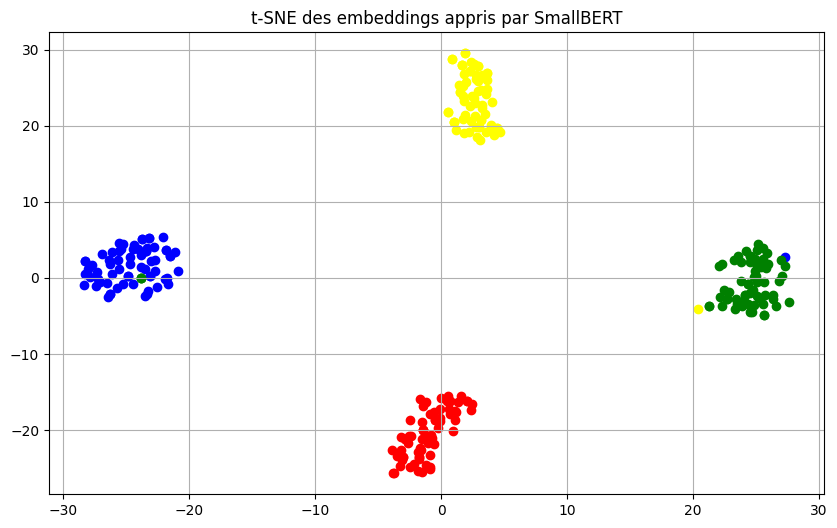

In [13]:
test_embeddings = text_encoder.predict(X_test_padded)
#perplexity : quand on exectue pooling,chaque point considere le relation avec combien des voisins
tsne = TSNE(n_components=2, perplexity=30,random_state=42)
reduced = tsne.fit_transform(test_embeddings)

label_names = {0: 'bike', 1: 'ball', 2: 'water', 3: 'dog'}
colors = ['red', 'yellow', 'blue', 'green']

plt.figure(figsize=(10, 6))
for label_id in range(4):
    #obtenir tous les points sur meme label_id
    points = reduced[y_test == label_id]
    plt.scatter(
        points[:, 0], points[:, 1], 
        c=colors[label_id],
        label=label_names[label_id]
    )

plt.title('t-SNE des embeddings appris par SmallBERT')
plt.grid(True)
plt.show()